<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 08 — Dimensionality Reduction

## 1) Summary

### 1.1 What is dimensionality reduction?
Dimensionality reduction transforms high-dimensional data **X ∈ R^D** into a lower-dimensional representation **Z ∈ R^d** where **d << D** while preserving as much useful information as possible.

There are two broad families:
- **Projection methods**: assume data lies near a lower-dimensional subspace (e.g., PCA).
- **Manifold learning methods**: assume data lies on (or near) a curved low-dimensional manifold embedded in high dimensions (e.g., t-SNE, LLE, Isomap).

### 1.2 Why we use it (typical benefits)
- **Speed**: training and inference become faster with fewer features.
- **Storage**: less memory/disk usage.
- **Noise reduction**: removing low-variance components can reduce noise.
- **Better generalization**: fewer degrees of freedom can reduce overfitting (not guaranteed).
- **Visualization**: 2D/3D embeddings help inspect clusters/outliers.

### 1.3 Key trade-offs / risks
- **Information loss**: some predictive signal may be discarded.
- **Interpretability**: transformed features may be harder to explain.
- **Manifold methods are often non-parametric** (some do not naturally map new points) and can be slow.

### 1.4 PCA (Principal Component Analysis) — core idea
PCA is the most widely used projection method.
- It finds orthogonal directions (principal components) that maximize variance.
- PC1 captures the largest variance, PC2 captures the largest remaining variance orthogonal to PC1, etc.
- PCA can be computed using **SVD** of the centered data matrix.

Important outputs:
- `explained_variance_ratio_`: fraction of variance explained by each component.
- `components_`: principal axes (directions) in feature space.

Choosing number of components:
- Pick **d** such that cumulative explained variance ≥ target (e.g., 95%).
- Or select using validation performance for the downstream model.

Reconstruction:
- You can map to low-dim and back using `inverse_transform`.
- Reconstruction error indicates how much information is lost.

### 1.5 PCA variants used in practice
- **IncrementalPCA**: train PCA in mini-batches (good for large datasets / streaming).
- **Randomized PCA**: fast approximate PCA using randomized SVD.
- **Kernel PCA**: nonlinear mapping via kernels (RBF, polynomial) to capture curved structures.

### 1.6 Random Projection (Johnson–Lindenstrauss idea)
Random projection uses a random matrix to project data into a lower-dimensional space while approximately preserving pairwise distances.
- Very fast and scalable.
- Often used as a baseline for high-dimensional sparse data.

### 1.7 Manifold Learning (t-SNE / LLE / Isomap)
Manifold methods aim to preserve **local neighborhood structure**:
- **t-SNE**: great for visualization (clusters), not ideal for preserving global distances; typically for 2D/3D visualization.
- **LLE**: preserves local linear relationships.
- **Isomap**: tries to preserve geodesic (manifold) distances.

---
## 2) What we will implement in this notebook
1. Load a high-dimensional dataset (MNIST if available, otherwise sklearn digits).
2. PCA: explained variance, selecting `n_components`, reconstruction visualization.
3. PCA variants: IncrementalPCA and randomized SVD option.
4. Kernel PCA (nonlinear) + a simple model evaluation.
5. Random Projection and distance preservation check.
6. Manifold learning visualization with t-SNE (2D).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 3) Load Dataset (MNIST if possible; fallback to Digits)

- MNIST: 70,000 images, 784 features (28×28 pixels)
- Digits (fallback): 1,797 images, 64 features (8×8 pixels)

We keep this notebook runnable even if OpenML download fails.

In [2]:
from sklearn.datasets import fetch_openml, load_digits

def load_mnist_or_digits():
    try:
        mnist = fetch_openml("mnist_784", as_frame=False)
        X = mnist["data"].astype(np.float32)
        y = mnist["target"].astype(np.uint8)
        # Normalize pixel values to [0,1]
        X /= 255.0
        return X, y, (28, 28), "MNIST"
    except Exception as e:
        digits = load_digits()
        X = digits.data.astype(np.float32)
        y = digits.target.astype(np.uint8)
        # Digits are already 0..16-ish; normalize to [0,1] for consistency
        X /= X.max()
        return X, y, (8, 8), "DIGITS"

X, y, img_shape, dataset_name = load_mnist_or_digits()
dataset_name, X.shape, y.shape, img_shape

('MNIST', (70000, 784), (70000,), (28, 28))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((56000, 784), (14000, 784))

## 4) Helper: visualize images

We define a helper to plot a few images (original vs reconstructed).

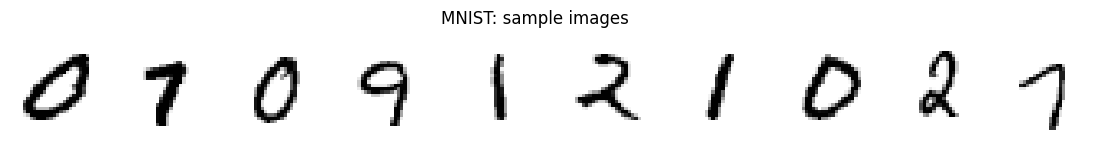

In [4]:
def plot_images(images, image_shape, n_rows=1, n_cols=10, title=None):
    plt.figure(figsize=(1.4*n_cols, 1.6*n_rows))
    for i in range(n_rows * n_cols):
        if i >= len(images):
            break
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].reshape(image_shape), cmap="binary")
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.show()

# show a few originals
plot_images(X_train[:10], img_shape, n_rows=1, n_cols=10, title=f"{dataset_name}: sample images")

# Part A — PCA (Principal Component Analysis)

## 5) PCA: explained variance and choosing `n_components`

We fit PCA and inspect `explained_variance_ratio_`:
- A common strategy is to pick the smallest `d` such that cumulative explained variance ≥ 95%.

In [5]:
from sklearn.decomposition import PCA

pca_full = PCA(random_state=42)
pca_full.fit(X_train)

explained = pca_full.explained_variance_ratio_
cumsum = np.cumsum(explained)

# Choose d to preserve 95% variance
d_95 = np.argmax(cumsum >= 0.95) + 1
d_95, cumsum[d_95 - 1]

(np.int64(154), np.float32(0.9503934))

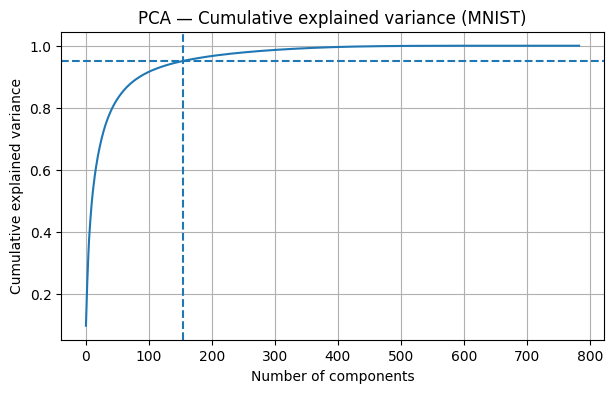

In [6]:
plt.figure(figsize=(7, 4))
plt.plot(cumsum)
plt.axhline(0.95, linestyle="--")
plt.axvline(d_95, linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title(f"PCA — Cumulative explained variance ({dataset_name})")
plt.grid(True)
plt.show()

## 6) PCA transform + inverse transform (reconstruction)

We compress data into `d_95` dimensions, then reconstruct back to the original space.
Visual inspection helps understand information loss.

In [7]:
pca = PCA(n_components=d_95, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_train_recon = pca.inverse_transform(X_train_reduced)

X_train_reduced.shape, X_train_recon.shape

((56000, 154), (56000, 784))

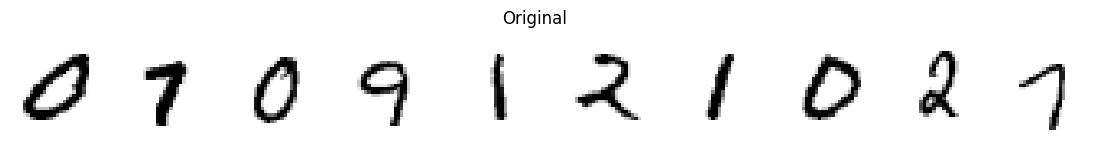

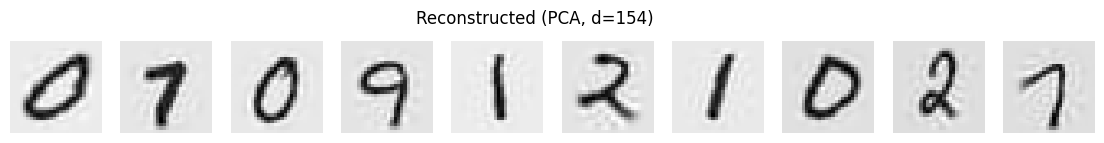

In [8]:
# Compare originals vs reconstructions
n = 10
plot_images(X_train[:n], img_shape, n_rows=1, n_cols=n, title="Original")
plot_images(X_train_recon[:n], img_shape, n_rows=1, n_cols=n, title=f"Reconstructed (PCA, d={d_95})")

## 7) Reconstruction error (MSE)

A simple quantitative measure: mean squared error between original and reconstructed inputs.
Lower is better (less information lost).

In [9]:
from sklearn.metrics import mean_squared_error

recon_mse = mean_squared_error(X_train, X_train_recon)
recon_mse

0.0033379471860826015

# Part B — PCA Variants

## 8) IncrementalPCA (mini-batch PCA)
IncrementalPCA is useful for large datasets or when you cannot fit PCA on all data at once.
We use a batch size and run `partial_fit` implicitly via `fit`.

In [10]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=d_95, batch_size=256)
X_train_reduced_ipca = ipca.fit_transform(X_train)
X_train_recon_ipca = ipca.inverse_transform(X_train_reduced_ipca)

ipca_mse = mean_squared_error(X_train, X_train_recon_ipca)
X_train_reduced_ipca.shape, ipca_mse

((56000, 154), 0.003359845327148469)

## 9) Randomized SVD in PCA (fast approximate)
`PCA(..., svd_solver="randomized")` often speeds up PCA for large datasets.
We compare shapes and reconstruction error (may differ slightly).

In [11]:
pca_rand = PCA(n_components=d_95, svd_solver="randomized", random_state=42)
X_train_reduced_rand = pca_rand.fit_transform(X_train)
X_train_recon_rand = pca_rand.inverse_transform(X_train_reduced_rand)
rand_mse = mean_squared_error(X_train, X_train_recon_rand)

X_train_reduced_rand.shape, rand_mse

((56000, 154), 0.0033617555163800716)

# Part C — Kernel PCA (Nonlinear dimensionality reduction)

## 10) Kernel PCA intuition
Kernel PCA applies PCA in an implicit feature space using kernels.
- Can capture nonlinear structure.
- Unlike standard PCA, it may help when data is not well-approximated by a linear subspace.

We demonstrate Kernel PCA on a small subset (for speed) and evaluate a simple classifier.

In [12]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Use a subset to keep runtime reasonable, especially for MNIST
n_subset = min(8000, X_train.shape[0])
X_sub = X_train[:n_subset]
y_sub = y_train[:n_subset]

X_sub_train, X_sub_val, y_sub_train, y_sub_val = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
)

kpca_clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if dataset_name=="MNIST" else StandardScaler()),
    ("kpca", KernelPCA(n_components=200 if dataset_name=="MNIST" else 30, kernel="rbf", gamma=0.03, fit_inverse_transform=False)),
    ("logreg", LogisticRegression(max_iter=2000, n_jobs=None))
])

kpca_clf.fit(X_sub_train, y_sub_train)
kpca_acc = kpca_clf.score(X_sub_val, y_sub_val)
kpca_acc

0.310625

**Note:** Kernel PCA can be expensive (memory/time) because it builds an N×N kernel matrix.
That’s why we run it on a subset.

# Part D — Random Projection

## 11) Random Projection overview
Random projection is a fast method to reduce dimensionality while approximately preserving distances.
We check how well pairwise distances are preserved on a subset.

In [13]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances

# subset for distance checks
n_dist = min(2000, X_train.shape[0])
X_dist = X_train[:n_dist]

grp = GaussianRandomProjection(n_components=200 if dataset_name=="MNIST" else 30, random_state=42)
X_proj = grp.fit_transform(X_dist)

# Compare pairwise distance distributions (approx check)
D_orig = pairwise_distances(X_dist, metric="euclidean")
D_proj = pairwise_distances(X_proj, metric="euclidean")

# Relative distortion stats (avoid divide by 0)
eps = 1e-12
rel_err = np.abs(D_proj - D_orig) / (D_orig + eps)

np.mean(rel_err), np.percentile(rel_err, [50, 90, 99])

(np.float32(0.040731013), array([0.03440368, 0.08402551, 0.13157188]))

Interpretation:
- Smaller relative error means better distance preservation.
- Random projection is approximate; it trades accuracy for speed/scalability.

# Part E — Manifold Learning (t-SNE for visualization)

## 12) t-SNE intuition
t-SNE is primarily for **2D/3D visualization**:
- Preserves local neighborhoods well.
- Often reveals clusters.
- Not ideal for measuring global distances, and typically slower than PCA.

We run t-SNE on a small subset and plot the embedding.

In [14]:
from sklearn.manifold import TSNE

n_vis = min(3000, X_train.shape[0])
X_vis = X_train[:n_vis]
y_vis = y_train[:n_vis]

# PCA pre-reduction helps speed up t-SNE and reduce noise
pca_vis = PCA(n_components=50 if dataset_name=="MNIST" else 30, random_state=42)
X_vis_pca = pca_vis.fit_transform(X_vis)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_embedded = tsne.fit_transform(X_vis_pca)
X_embedded.shape

(3000, 2)

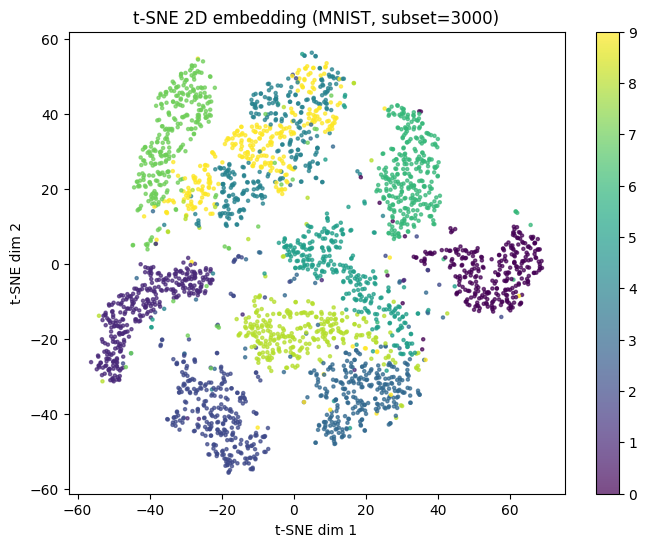

In [15]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_vis, s=5, alpha=0.7)
plt.colorbar(scatter)
plt.title(f"t-SNE 2D embedding ({dataset_name}, subset={n_vis})")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

## 13) Takeaways
- Dimensionality reduction is useful for speed, storage, denoising, and visualization, but can lose information.
- PCA is the standard linear projection method; `explained_variance_ratio_` helps choose `n_components`.
- `inverse_transform` enables reconstruction and measuring information loss (e.g., MSE).
- IncrementalPCA and randomized SVD make PCA more scalable.
- Kernel PCA can capture nonlinear structure but can be computationally expensive.
- Random projection is very fast and often preserves distances reasonably well.
- t-SNE is excellent for visualization (local structure), not for general-purpose feature engineering in production.

## 14) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 8.
- scikit-learn documentation: PCA, IncrementalPCA, KernelPCA, RandomProjection, t-SNE.